In [ ]:
!pip install opendatasets -q

# Import Libraries

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import opendatasets as od
from warnings import simplefilter

In [6]:
simplefilter("ignore")

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'

# Data Loading

In [7]:
od.download("https://www.kaggle.com/datasets/ryanholbrook/ts-course-data")

100%|██████████| 120k/120k [00:00<00:00, 31.4MB/s]

In [8]:
tunnel = pd.read_csv("/content/ts-course-data/tunnel.csv", parse_dates=['Day'])
tunnel = tunnel.set_index("Day").to_period()

In [13]:
tunnel.head()

,NumVehicles
Day,
2003-11-01,103536
2003-11-02,92051
2003-11-03,100795
2003-11-04,102352
2003-11-05,106569


# Data Preparation

<Axes: title={'center': 'Tunnel Traffic - 365-Day Moving Average'}, xlabel='Day'>

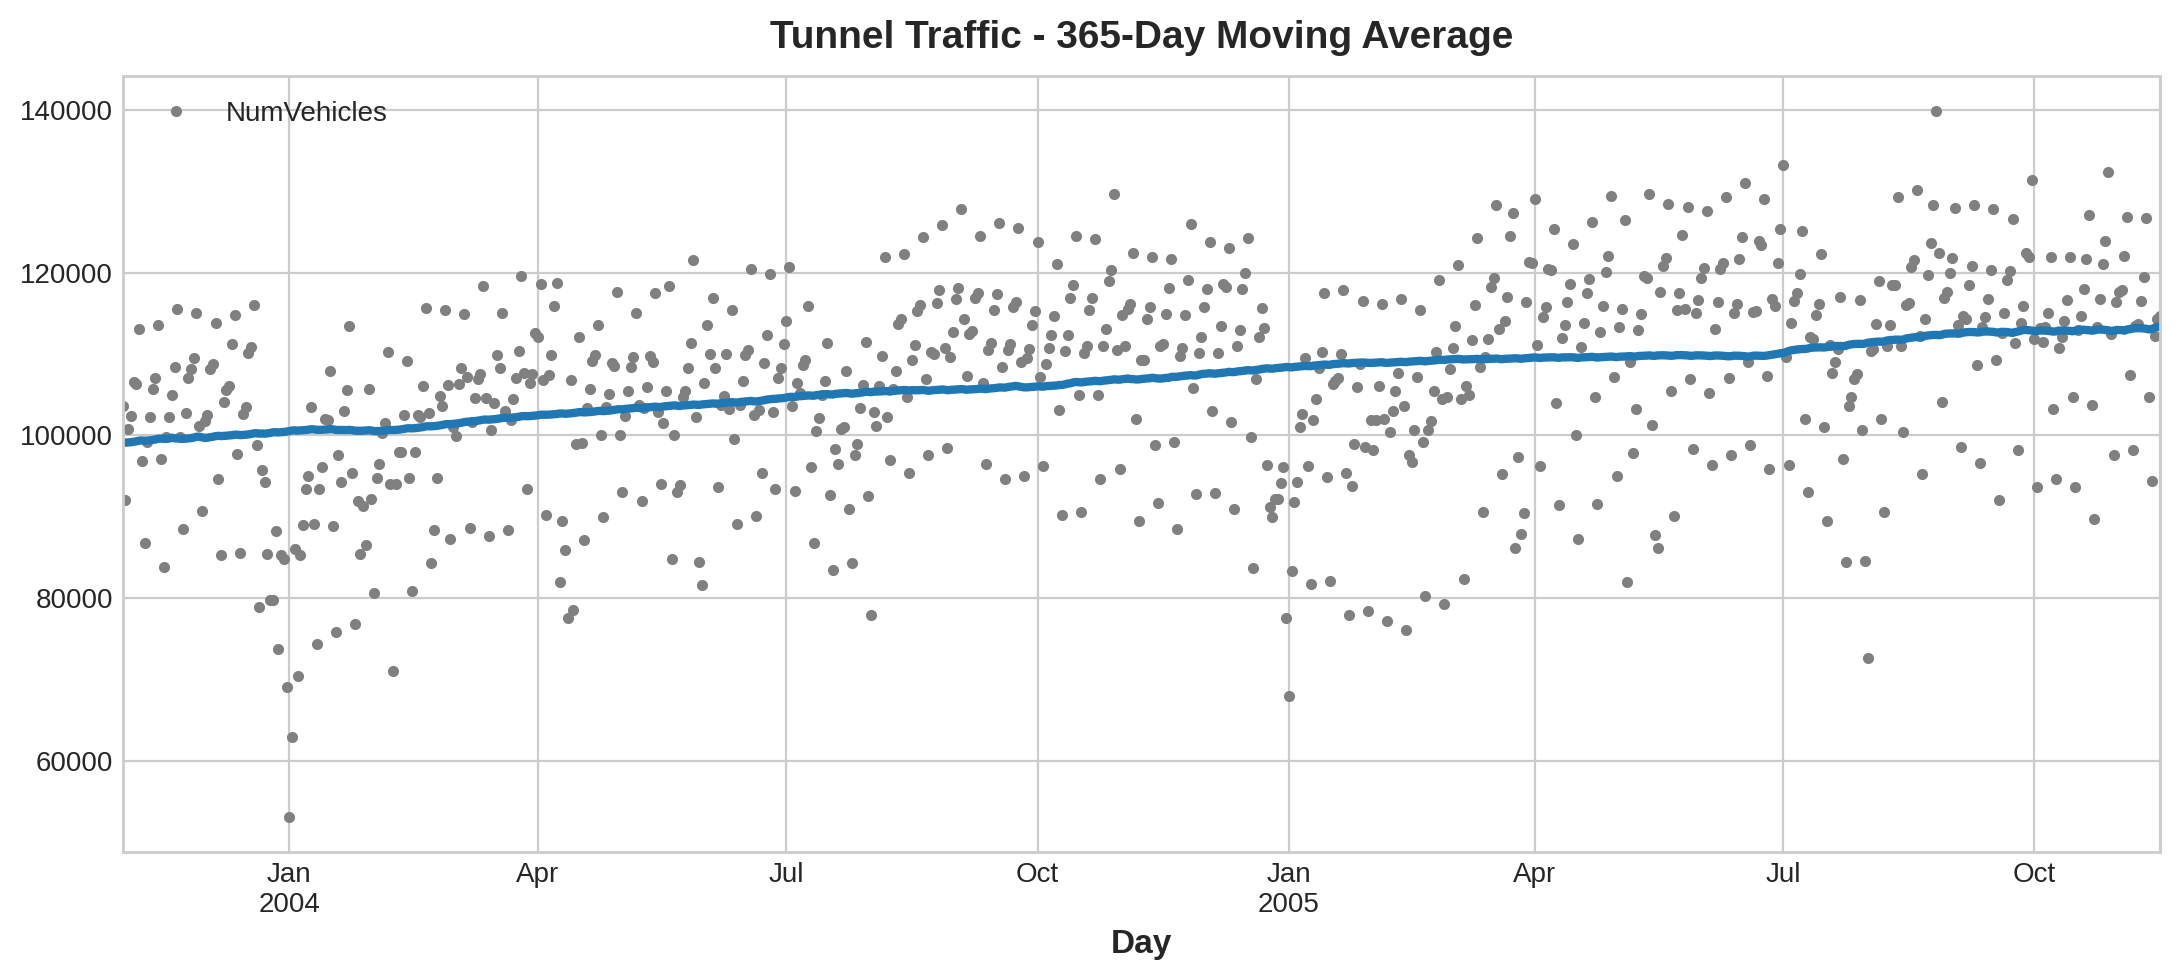

In [9]:
moving_average = tunnel.rolling(
    window=365, # 365 day window
    center=True, # puts the average at the center of the window
    min_periods=183 # choose half the window size
).mean() # compute the mean

ax = tunnel.plot(style=".", color="0.5")
moving_average.plot(
    ax=ax, linewidth=3, title="Tunnel Traffic - 365-Day Moving Average", legend=False
)

## Create time dummy with trend

In [12]:
from statsmodels.tsa.deterministic import DeterministicProcess

dp = DeterministicProcess(
    index=tunnel.index, # Dates from the training data
    constant=True, # dummy feature for the bias (y_intercept)
    order=1, # the time dummy (trend)
    drop=True # drop terms if necessary to avoid collinearity
)
# 'in_sample' creates features for the dates given in the 'index' argument
X = dp.in_sample()
X.head()

,const,trend
Day,,
2003-11-01,1.0,1.0
2003-11-02,1.0,2.0
2003-11-03,1.0,3.0
2003-11-04,1.0,4.0
2003-11-05,1.0,5.0


# Modelling

In [14]:
from sklearn.linear_model import LinearRegression

y = tunnel['NumVehicles'] # the target

# The intercept is the same as the `const` feature from
# DeterministicProcess. LinearRegression behaves badly with duplicated
# features, so we need to be sure to exclude it here.
model = LinearRegression(fit_intercept=False)
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

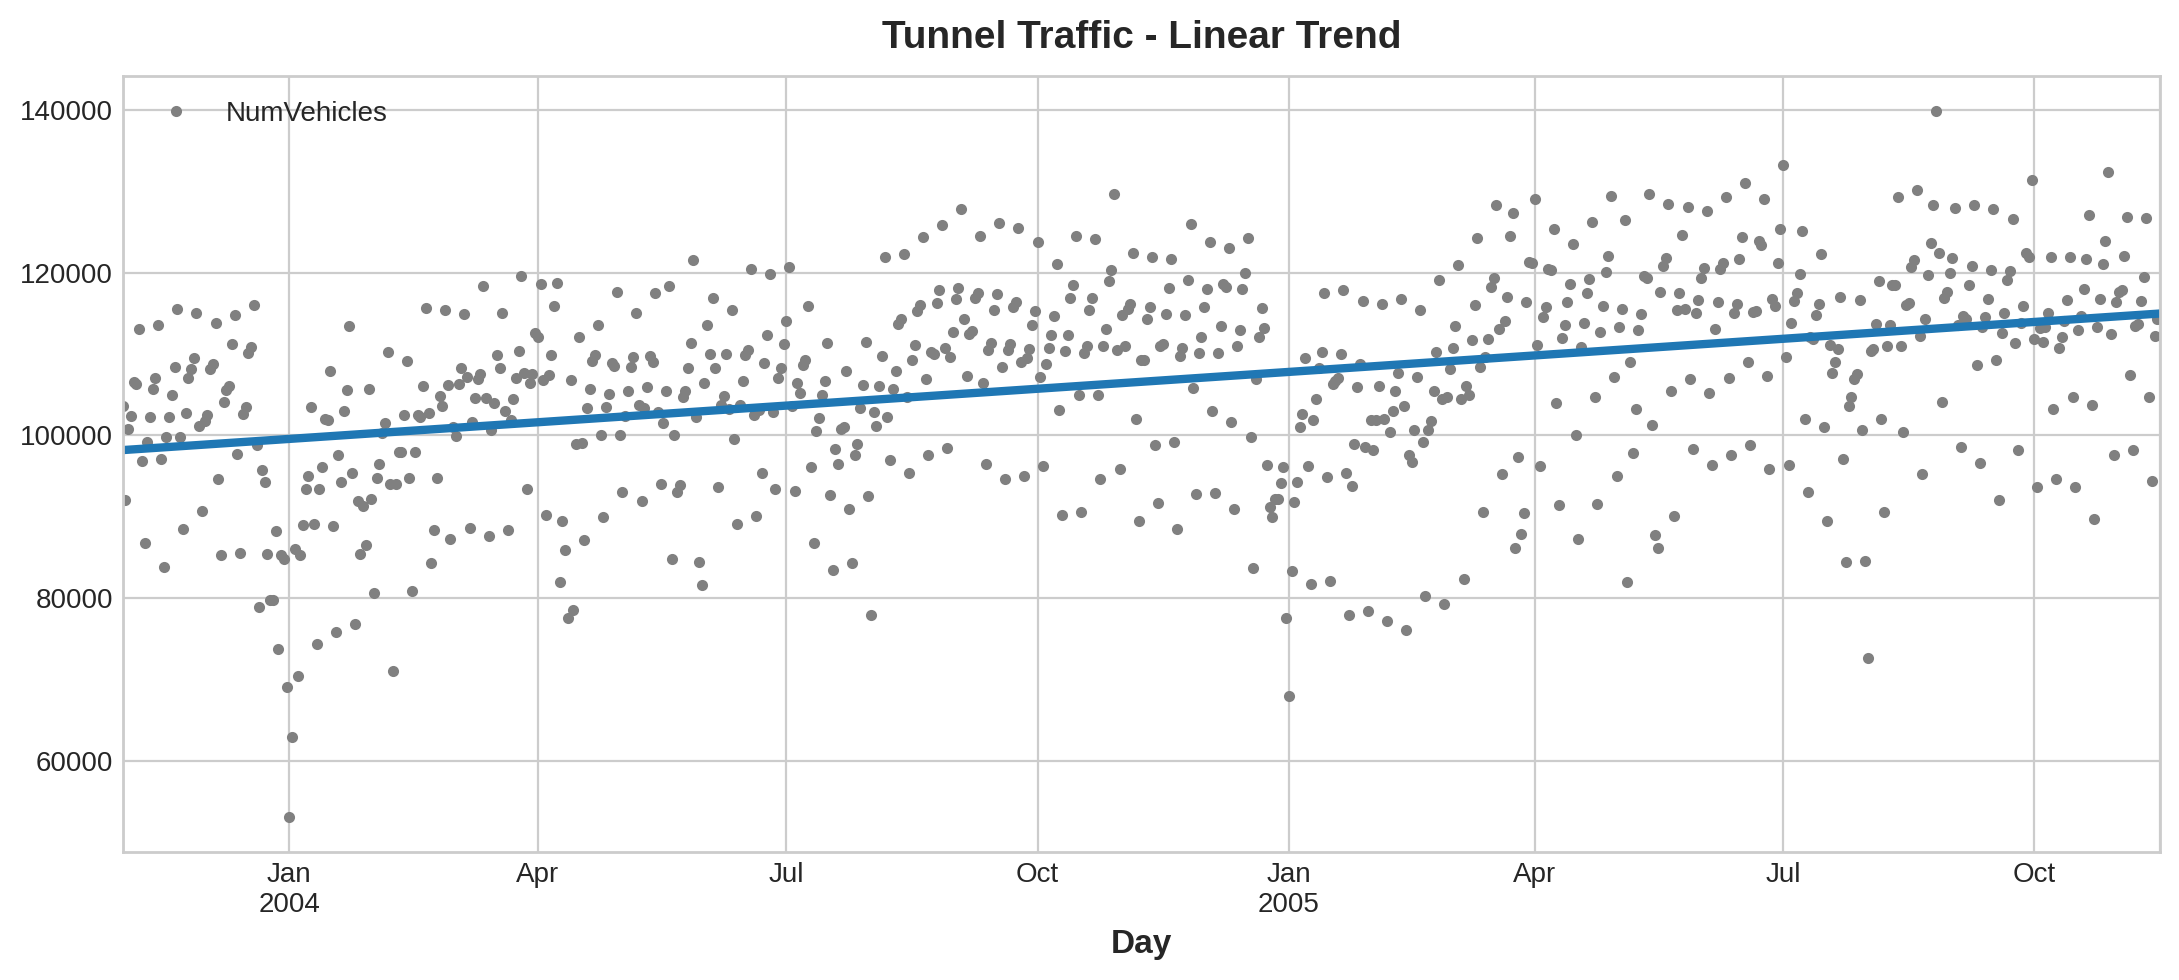

In [16]:
ax = tunnel.plot(style=".", color="0.5", title="Tunnel Traffic - Linear Trend")
_ = y_pred.plot(ax=ax, linewidth=3, label="Trend")

# Make a Forecast

In [17]:
X = dp.out_of_sample(steps=30)

y_fore = pd.Series(model.predict(X), index=X.index)

y_fore.head()

2005-11-17    114981.801146
2005-11-18    115004.298595
2005-11-19    115026.796045
2005-11-20    115049.293494
2005-11-21    115071.790944
Freq: D, dtype: float64

## Plot the trend forecast for the next 30 days

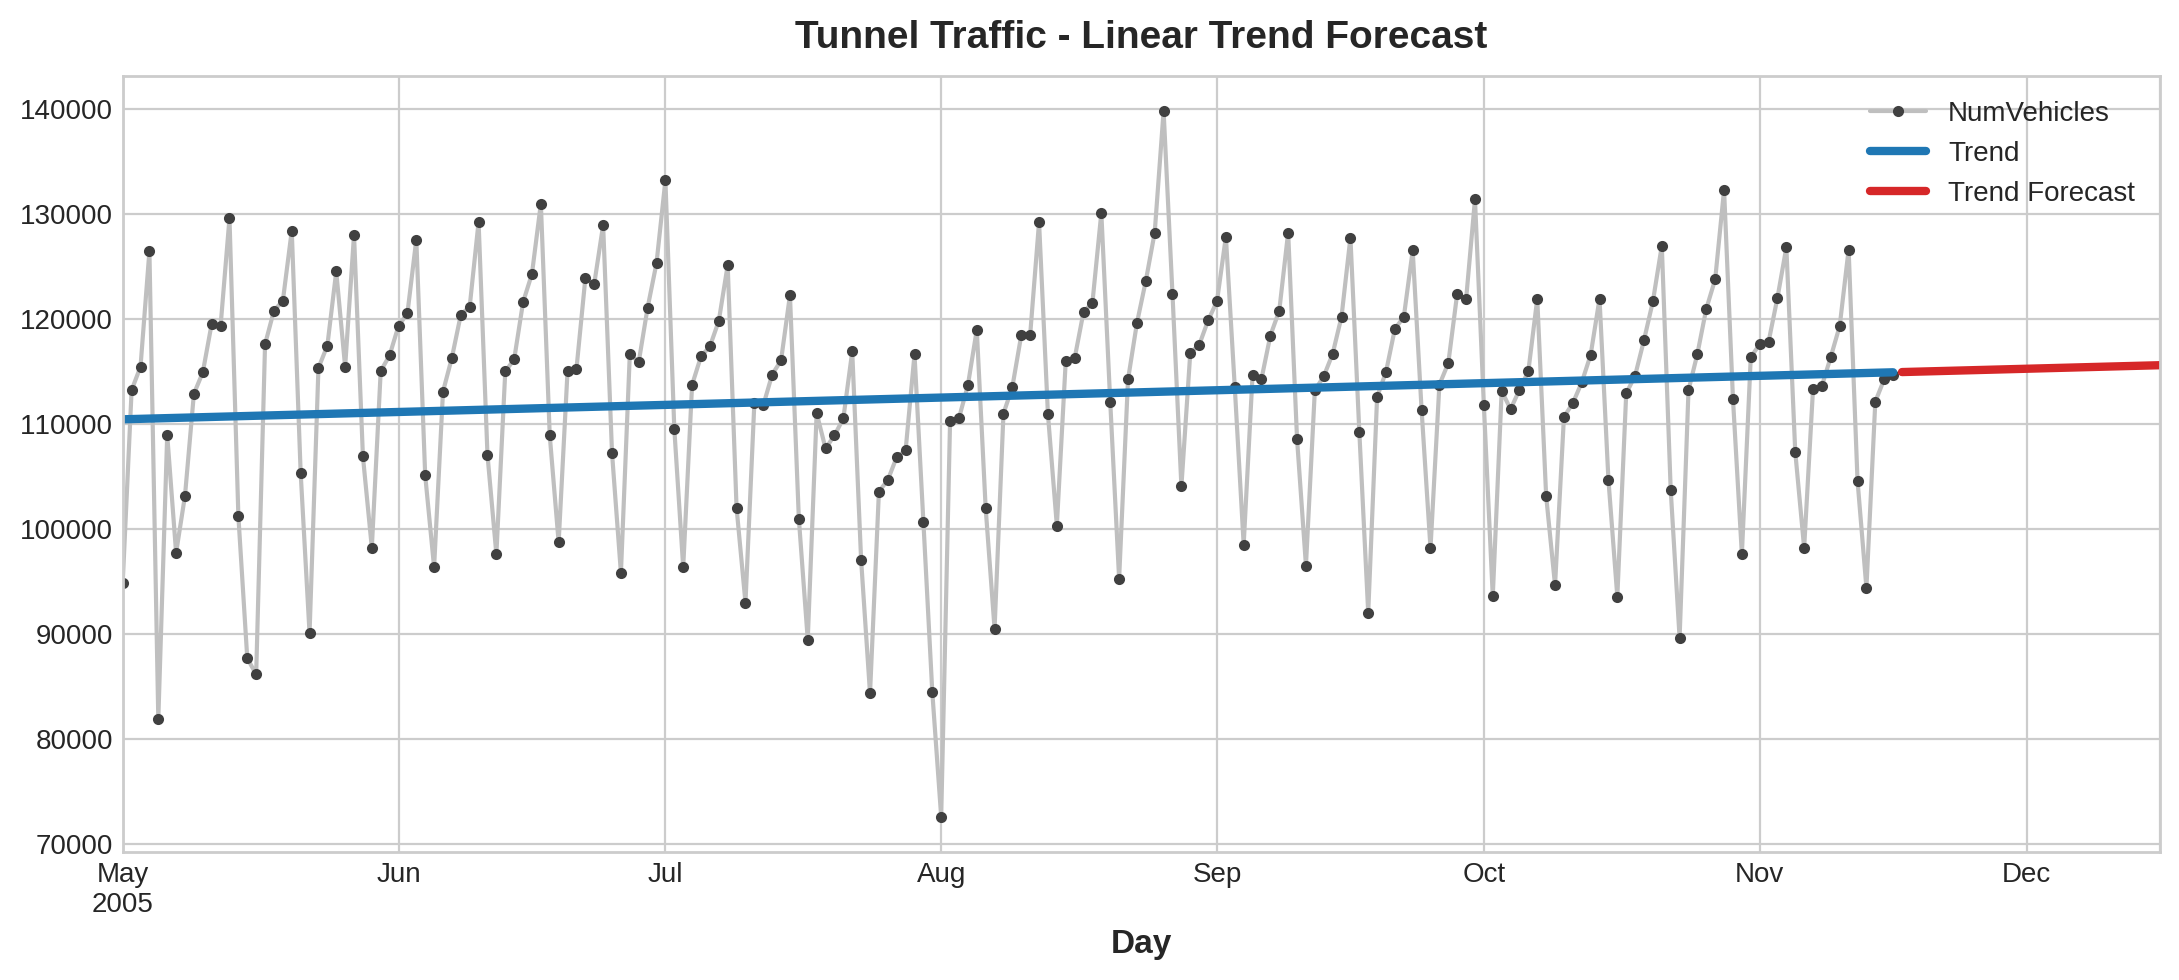

In [18]:
ax = tunnel['2005-05':].plot(title="Tunnel Traffic - Linear Trend Forecast", **plot_params)
ax = y_pred['2005-05':].plot(ax=ax, linewidth=3, label='Trend')
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color="C3")
_ = ax.legend()